# X-ray absorption spectroscopy broadening

The [Lightshow](https://github.com/AI-multimodal/Lightshow) software package is a one-stop-shop for writing computational spectroscopy input files. It also contains various utilities for dealing with spectroscopy data. In this tutorial, we'll show you how to use `lightshow.postprocessing` to broaden spectra. Specifically, the Ti X-ray absorption near-edge structure (XANES) K-edge spectrum of Anatase. We'll compare various simulated results to an experimental spectrum.

📝 **Note:** This notebook is a tutorial designed to be run via online hosting services, but you can of course run it locally, it just might require a few modifications.

📝 **Note:** You can find our arXiv Preprint here: https://arxiv.org/abs/2211.04452.

In [ ]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

## Summary

We'll consider the following types of broadening in this work:

**Gaussian**
$$G(x; \sigma) \equiv \frac{e^{-x^{2} /\left(2 \sigma^{2}\right)}}{\sigma \sqrt{2 \pi}}$$


**Lorentzian**
$$L(x; \Gamma) \equiv \frac{\frac{1}{2}\Gamma}{\pi\left(x^{2}+(\frac{1}{2}\Gamma)^{2}\right)}$$


**Voigt**
$$V(x; \sigma, \Gamma) \equiv \int_{-\infty}^{\infty} G\left(x^{\prime} ; \sigma\right) L\left(x-x^{\prime} ; \Gamma\right) d x^{\prime}$$


**Energy-dependent Voigt**

This uses an energy dependent value for $\Gamma$

$$\Gamma\left(E\right)=\Gamma_0+\alpha(E-E_\mathrm{f})$$

in Voigt function, where $\Gamma_0$ and $\alpha$ are constants. $E_\mathrm{f}$ is the Fermi energy. More details can be found at [Herbert. Practical aspects of running the WIEN2k code for electron spectroscopy](https://doi.org/10.1016/j.micron.2006.03.010).

# Install Lightshow

You can install lightshow via `pip` in this single command!

In [ ]:
!pip install lightshow

Plotting utilities:

In [11]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['text.usetex'] = False
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)
mpl.rcParams['figure.dpi'] = 300

The `SiteSpectrum` contains everything we'll need.

In [12]:
from lightshow.postprocess.broaden import SiteSpectrum

# Download spectral data

We can use the [GitHub Contents API](https://docs.github.com/en/rest/repos/contents?apiVersion=2022-11-28#about-repository-contents) to download the `spectra_files` directory.

In [ ]:
!curl https://codeload.github.com/AI-multimodal/Lightshow/tar.gz/master | tar -xz --strip=2 Lightshow-master/notebooks/spectra_files

# Demo

## Load the files

In [13]:
# Experimental data
experimental_spectrum = np.loadtxt('spectra_files/anatase_exp.txt')

# Anatase TiO2 theoretical simulations
vasp_data_loaded = np.loadtxt('spectra_files/anatase_theory_VASP.txt')
feff_data_loaded = np.loadtxt("spectra_files/anatase_theory_FEFF.txt")

## Using manual parameters to broaden the XAS simulation

Anatase TiO$_2$ experimental data is derived from Yan _et al_. [Ultrathin amorphous titania on nanowires: Optimization of conformal growth and elucidation of atomic-scale motifs.](https://doi.org/10.1021/acs.nanolett.8b04888) Nano Lett. **19**, 3457 (2019).

In [14]:
# Some information we'll need for the energy-dependent Voigt broadening
TiK_core_state = -4864.0371       
TiK_core_hole_lifetime = 0.89
ana_core_hole_fermi_energy = 5.1302
e_fermi = ana_core_hole_fermi_energy - TiK_core_state 

In [15]:
vasp_spectrum = SiteSpectrum(vasp_data_loaded.copy(), e_fermi=e_fermi)

# Align this data to experiment
vasp_spectrum.align_to_experiment_(experimental_spectrum)
vasp_spectrum.scale_max_to_1_()

# Example of broadening the vasp spectrum with Gaussian broadening and sigma=1
x = np.linspace(4900, 5100, 1000)
vasp_spectrum_G_broadened = vasp_spectrum.broaden(x, method="Gaussian", sigma=1.0)

# ... using Lorentzian broadening
vasp_spectrum_L_broadened = vasp_spectrum.broaden(x, method="Lorentzian", gamma=1.0)

# ... using Voigt broadening
vasp_spectrum_V_broadened = vasp_spectrum.broaden(x, method="Voigt", sigma=0.5, gamma=0.5)

# ... using energy-dependent Voigt broadening
vasp_spectrum_EDV_broadened = vasp_spectrum.broaden(
    x,
    method="energy_dependent_voigt_broaden",
    sigma=0.2,
    alpha=0.025,
    lifetime=TiK_core_hole_lifetime
)

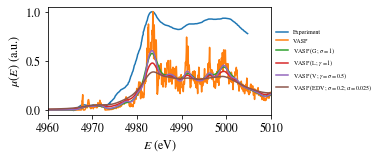

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2))

ax.plot(experimental_spectrum[:, 0], experimental_spectrum[:, 1], label='Experiment')
ax.plot(vasp_spectrum.spectrum[:, 0], vasp_spectrum.spectrum[:, 1], label='VASP')
ax.plot(x, vasp_spectrum_G_broadened, label=r'VASP (G; $\sigma=1$)')
ax.plot(x, vasp_spectrum_L_broadened, label=r'VASP (L; $\gamma=1$)')
ax.plot(x, vasp_spectrum_V_broadened, label=r'VASP (V; $\gamma=\sigma=0.5$)')
ax.plot(x, vasp_spectrum_EDV_broadened, label=r'VASP (EDV; $\sigma=0.2;\alpha=0.025$)')


ax.legend(frameon=False, bbox_to_anchor=(1, 0.5), loc="center left", fontsize=6)
ax.set_ylabel("$\mu(E)$ (a.u.)")
ax.set_xlabel("$E$ (eV)")
ax.set_xlim(4960, 5010)

plt.show()

#### There are some issues here:
1. The broadening parameter is not necessarily correct.
2. Even after doing the align-by-maxima procedure, the spectra are clearly not aligned (look at the edge locations).

We will address these problems in the future!